In [ ]:
#!pip install vam.whittaker
#!pip install cython
#!pip install openeo

In [1]:
import openeo
import datetime
import numpy as np
import matplotlib.pyplot as plt
import vam.whittaker
from vam.whittaker import  ws2d, ws2dp, ws2doptv, lag1corr
import pandas as pd
from datetime import datetime, timedelta
import math
from shapely.geometry import box
from openeo.rest.conversions import timeseries_json_to_pandas
import time

In [2]:
#connect with VITO backend
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


Custom functions

In [3]:
def whittaker_f(x,y,lmbd,d):

    #minimum and maximum dates
    min=x[0].toordinal()
    max=x[-1].toordinal()
    l=max-min

    v=np.full(l+1,-3000)
    t=np.full(l+1,0,dtype='float')

    D=[]
    for i in x:
        D.append(i.toordinal())


    D1=np.array(D)-D[0]
    D11=D1[~np.isnan(Ym)]
    v[D11]=1
    t[D11]=Ym[~np.isnan(Ym)]

    # dates
    xx = [x[0] + timedelta(days=i) for i in range(l+1)] #try using pandas instead?

    # create weights
    w = np.array((v!=-3000)*1,dtype='double')

    # apply filter
    z_ = ws2d(t,lmbd,w)
    z1_ = np.array(z_)
    
    #return z1_,xx
    
    if isinstance(d, int):     
        if d>0 and d<z1_.size:            
            n=z1_.size
            ind=[i*d for i in range(math.ceil(n/d))]
            Zd=z1_[ind]
            XXd=[xx[ii] for ii in ind] 
        else:
            Zd=[]
            XXd=[]
            print ("d must be positive and smaller than the total number of dates")
    else:
        Zd=[]
        XXd=[]
        print ("d must be an integer")
    
    return z1_,xx,Zd,XXd
    
    
    

In [4]:
# Rye 
x,y,x1,y1=(-4.867495201109149, 41.77850665915476, -4.865177772520282, 41.780106793555454)
point_area= box(x,y,x1,y1)

# Rapeseed
##point_area= box(-4.875091217039325, 41.77290587433312, -4.872773788450457, 41.77450614847532)
#x,y,x1,y1=(-4.875091217039325, 41.77290587433312, -4.872773788450457, 41.77450614847532)
#point_area= box(x,y,x1,y1)

# Barley
#point_area= box(-4.879382751463153, 41.76996126559408,-4.8770653228742855, 41.77156161319915)
#x,y,x1,y1=(-4.879382751463153, 41.76996126559408,-4.8770653228742855, 41.77156161319915)
#point_area= box(x,y,x1,y1)

# Wheat 
#point_area= box(-4.851616523740985, 41.763015294346935, -4.8492990951521175, 41.76461581522523)
#x,y,x1,y1=(-4.851616523740985, 41.763015294346935, -4.8492990951521175, 41.76461581522523)
#point_area= box(x,y,x1,y1)

# Barley test pixel
# x,y=(-4.86496925354004, 41.77214384798264)
#point_area = box(x, y,x+0.0001,y+0.0001)

spat_ext = {"west":x, "east":x1, "south":y, "north":y1}
temp_ext = ["2017-04-11","2020-12-31"]

In [5]:
s2 = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["B04","B08","SCL"])
s2_cloudmasked = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
ndvi_cube = s2.ndvi(red="B04", nir="B08")
ndvi_cube_cloudmasked = s2_cloudmasked.ndvi(red="B04", nir="B08")

In [6]:
cubes_dfs = []
for cube in [ndvi_cube, ndvi_cube_cloudmasked]:
    point_timeseries = cube.polygonal_mean_timeseries(point_area).execute()
    df = timeseries_json_to_pandas(point_timeseries)
    df.index = pd.to_datetime(df.index)
    cubes_dfs.append(df)    

In [7]:
joined_df = pd.concat(cubes_dfs, axis=1)
joined_df = joined_df.rename(columns={0: 'NDVI', 1: 'NDVI_cloudmasked'})

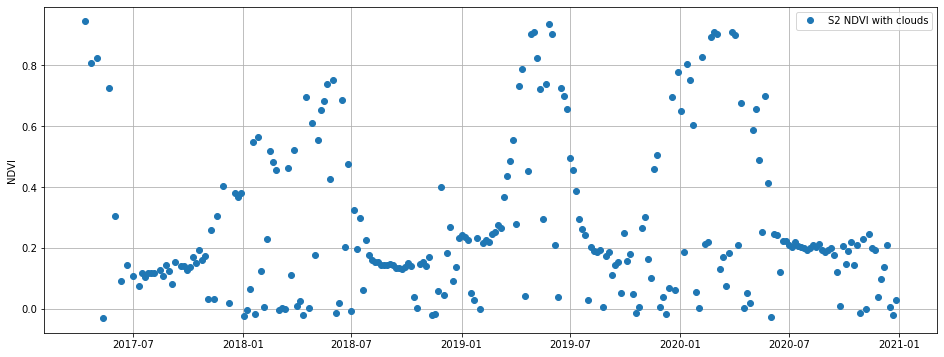

In [8]:
plt.figure(figsize= (16,6))
plt.plot(joined_df.index, joined_df['NDVI'], 'o', label='S2 NDVI with clouds')
plt.ylabel ('NDVI')
plt.grid(True)
plt.legend()

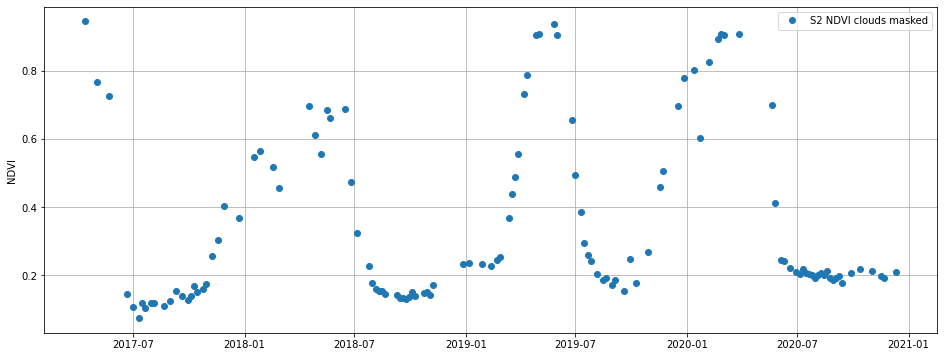

In [9]:
plt.figure(figsize= (16,6))
plt.plot(joined_df.index, joined_df['NDVI_cloudmasked'], 'o', label='S2 NDVI clouds masked')
plt.ylabel ('NDVI')
plt.grid(True)
plt.legend()

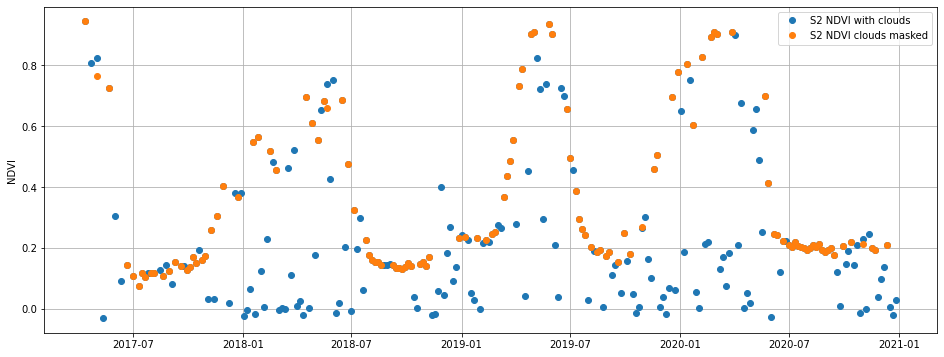

In [11]:
plt.figure(figsize= (16,6))
plt.plot(joined_df.index, joined_df['NDVI'], 'o', label='S2 NDVI with clouds')
plt.plot(joined_df.index, joined_df['NDVI_cloudmasked'], 'o', label='S2 NDVI clouds masked')
plt.ylabel ('NDVI')
plt.grid(True)
plt.legend()

In [12]:
#Apply Whittaker filter to time series
start_time = time.time()
lmbd=100
d=10
X=joined_df.index.tolist()
#Y=df_S2['NDVI_clouds'].values 
#Z,XX=whittaker_f(X, Y, lmbd)
Ym=joined_df['NDVI_cloudmasked'].values 
Z,XX,Zd,XXd=whittaker_f(X, Ym, lmbd,d)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.010944604873657227 seconds ---


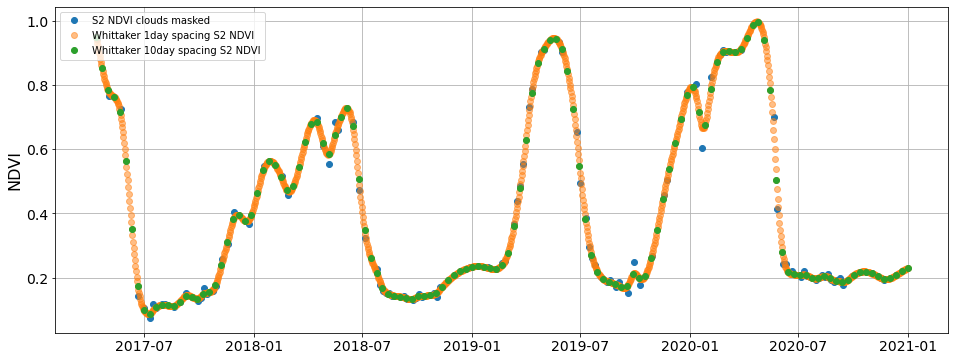

In [13]:
plt.figure(figsize= (16,6))
#plt.plot(X,Y,'o',label='S2 original NDVI')
plt.plot(joined_df.index, joined_df['NDVI_cloudmasked'], 'o', label='S2 NDVI clouds masked')
plt.plot(XX,Z,'o',alpha=0.5, label='Whittaker 1day spacing S2 NDVI')
plt.plot(XXd,Zd,'o', label='Whittaker %sday spacing S2 NDVI'% d)
plt.ylabel ('NDVI',fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True)
plt.legend(loc='upper left')